In [2]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.metrics import r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor

*Carregamento e preparação dos dados*

In [5]:
# Importar os dados pré-processados
df = pd.read_csv(
    r"data\dados_preprocessados_temp_rj.csv",
    index_col="time",
    parse_dates=True
)

# Visualizar dados
df

,TAMB,seno_mes,cos_mes,media_movel_3m,media_movel_12m,std_movel_3m,std_movel_12m,TARGET
time,,,,,,,,
1991-12-01,26.519355,-2.449294e-16,1.000000e+00,24.443082,23.412252,1.866790,2.128632,25.835484
1992-01-01,25.835484,5.000000e-01,8.660254e-01,25.420502,23.476499,1.354877,2.193676,26.065517
1992-02-01,26.065517,8.660254e-01,5.000000e-01,26.140119,23.488506,0.347985,2.208618,26.029032
1992-03-01,26.029032,1.000000e+00,6.123234e-17,25.976678,23.530173,0.123631,2.254846,25.043333
1992-04-01,25.043333,8.660254e-01,-5.000000e-01,25.712628,23.583506,0.579913,2.284747,23.738710
...,...,...,...,...,...,...,...,...
2025-05-01,22.619355,5.000000e-01,-8.660254e-01,24.520179,24.187899,1.922950,2.190660,21.296667
2025-06-01,21.296667,1.224647e-16,-1.000000e+00,22.797563,24.065954,1.597473,2.314594,19.716129
2025-07-01,19.716129,-5.000000e-01,-8.660254e-01,21.210717,23.964610,1.453520,2.484653,20.909677


*Exploração inicial dos dados*

,TARGET
count,406.000000
mean,23.791794
std,2.241930
min,19.277419
25%,21.901613
50%,23.811505
75%,25.769605
max,28.864286


<Axes: xlabel='time'>

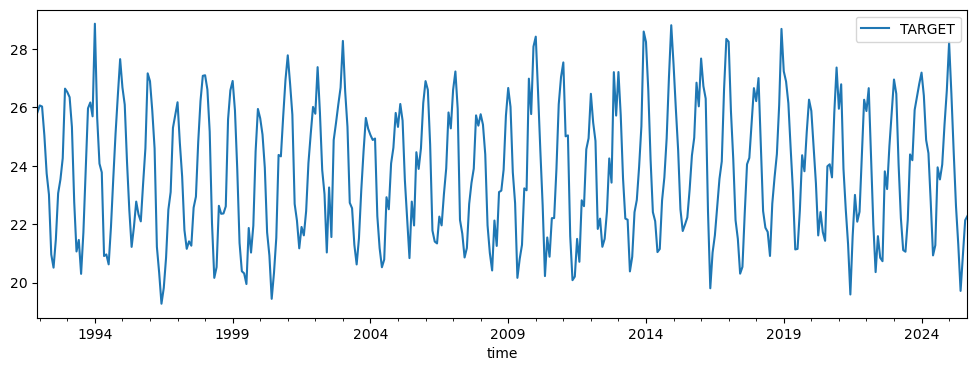

In [ ]:
# Breve análise descritiva com estatísticas básicas dos dados
display(df[["TARGET"]].describe())

# Vizualizar dados de forma visual (gráfico de linha)
df[["TARGET"]].plot(figsize=(12, 4))

<Axes: ylabel='Count'>

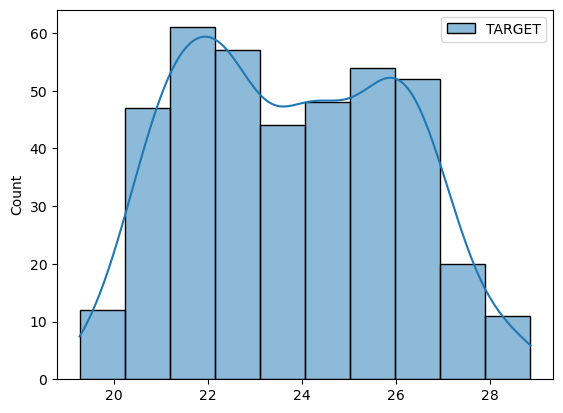

In [8]:
# Vizualizar distribuição dos dados (gráfico de histograma)
sns.histplot(df[["TARGET"]], kde=True)

*Preparação dos dados para treinamento*

In [9]:
# Criando uma cópia dos dados originais 
df_preprocessado = df.copy()

In [10]:
df_preprocessado.head(5)

,TAMB,seno_mes,cos_mes,media_movel_3m,media_movel_12m,std_movel_3m,std_movel_12m,TARGET
time,,,,,,,,
1991-12-01,26.519355,-2.449294e-16,1.000000e+00,24.443082,23.412252,1.866790,2.128632,25.835484
1992-01-01,25.835484,5.000000e-01,8.660254e-01,25.420502,23.476499,1.354877,2.193676,26.065517
1992-02-01,26.065517,8.660254e-01,5.000000e-01,26.140119,23.488506,0.347985,2.208618,26.029032
1992-03-01,26.029032,1.000000e+00,6.123234e-17,25.976678,23.530173,0.123631,2.254846,25.043333
1992-04-01,25.043333,8.660254e-01,-5.000000e-01,25.712628,23.583506,0.579913,2.284747,23.738710


In [11]:
# Separação dos dados em TARGET (y) e FEATURES (x)
# Target = Variável Prevista = Y
y_target = df_preprocessado[["TARGET"]]

# Features = Variáve(is) Preditora(s) = X
# Nesse caso, temos temperatura diária registrada 1 mês atrás
x_features = df_preprocessado.drop(columns=["TARGET"])

In [12]:
# Separação em treino e teste 
# Seguiremos uma separação padrão de ~70% para treino e ~30% para teste 

# Primeiros 25 anos destinados para treinamento (1991 - 2015)
y_train = y_target["1991":"2015"]
x_train = x_features["1991":"2015"]

# Últimos 10 anos destinados para teste/validação (2016 - 2025)
y_test = y_target["2016":]
x_test = x_features["2016":]

# Visualizando percentuais das amostras 
pct_treino = (len(y_train) / len(y_target)) * 100
print(f"-- Percentual de dados para treinamento: {pct_treino: .0f}%")

pct_teste = (len(y_test) / len(y_target)) * 100
print(f"-- Percentual de dados para treinamento: {pct_teste: .0f}%")

-- Percentual de dados para treinamento:  71%
-- Percentual de dados para treinamento:  29%


*Treinamento do modelo*

In [25]:
# Modelo escolhido -> XGBoost -> Modelo de gradiente
# Bastante utilizado em séries temporais 

modelo = XGBRegressor()

# Modelo parametrizado 
modelo = XGBRegressor(
      random_state=42,
      n_estimators=100,
      learning_rate=0.1,
      max_depth=3,
      colsample_bytree=0.8,
      subsample=0.8,
      reg_alpha=0.1,
      reg_lambda=0.1,
)

# Treinar modelo com dados de treinamento
modelo.fit(x_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [26]:
# Buscar previsões nas amostras de treino e teste para validação
pred_train = pd.DataFrame(modelo.predict(x_train), index=x_train.index, columns=["Y_PRED"])
pred_test = pd.DataFrame(modelo.predict(x_test), index=x_test.index, columns=["Y_PRED"])

# Visualizar previsões
# modelo.predict(x_features)
pred_test


,Y_PRED
time,
2016-01-01,27.300430
2016-02-01,26.147217
2016-03-01,25.884535
2016-04-01,22.983454
2016-05-01,21.998316
...,...
2025-05-01,20.955393
2025-06-01,20.948774
2025-07-01,20.742393


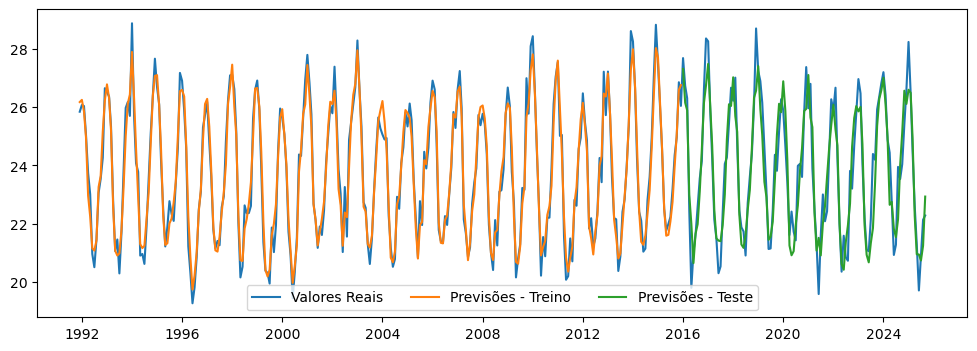

In [27]:
### Plotar previsões vs. dados reais

# Criando figura
fig, ax = plt.subplots(figsize=(12, 4))

# Plotando dados 
ax.plot(y_target, label="Valores Reais")
ax.plot(pred_train, label="Previsões - Treino")
ax.plot(pred_test, label="Previsões - Teste")

ax.legend(ncols=3)

In [28]:
# R2 -> coeficiente de determinação
# -> mostra quanto de variância total dos seus dados seu modelo consegue explicar
# -> mostra quão bem seu modelo explica o comportamento da sua série
# -> quanto maior melhor

r2_test = r2_score(y_true=y_test, y_pred=pred_test)
r2_train = r2_score(y_true=y_train, y_pred=pred_train)

print(f"-- Valores de R² -> Treino: {r2_train: .2f} | Teste: {r2_test: .2f}")

# MAPE -> erro médio absoluto percentual
# -> medida de erro global do seu modelo
# -> quanto menor melhor 

mape_test = mean_absolute_percentage_error(y_true=y_test, y_pred=pred_test) * 100
mape_train = mean_absolute_percentage_error(y_true=y_train, y_pred=pred_train) * 100

print(f"-- Valores de MAPE -> Treino: {mape_train: .2f} | Teste: {mape_test: .2f}%")

-- Valores de R² -> Treino:  0.96 | Teste:  0.85
-- Valores de MAPE -> Treino:  1.50 | Teste:  2.97%
